In [328]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import texthero as hero
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


# Carregando e limpando os dados

In [311]:
pagamentos = pd.read_csv('pagamentos.csv')
pagamentos.info()
# pagamentos.value_counts()
print(pagamentos.nunique())
pagamentos.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427873 entries, 0 to 427872
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   data_publicacao          427873 non-null  object
 1   fase                     427873 non-null  object
 2   credor                   427873 non-null  object
 3   valor                    427873 non-null  object
 4   numero                   427873 non-null  object
 5   cpf_ou_cnpj              427873 non-null  object
 6   data_pagamento           427873 non-null  object
 7   numero_processo          253290 non-null  object
 8   bem_ou_servico_prestado  420978 non-null  object
 9   natureza                 422333 non-null  object
 10  acao                     407378 non-null  object
 11  funcao                   407414 non-null  object
 12  subfuncao                407405 non-null  object
 13  processo_licitatorio     407396 non-null  object
 14  fonte_recurso       

,data_publicacao,fase,credor,valor,numero,cpf_ou_cnpj,data_pagamento,numero_processo,bem_ou_servico_prestado,natureza,acao,funcao,subfuncao,processo_licitatorio,fonte_recurso
0,01/01/2010,EMPENHO,METALPIRES INDUSTRIA E COM LT,"R$ 203.690,00",10000348,06.965.538/0001-00,01/01/2010,157/2009,REF AQUISICAO DE MOBILIARIOS E EQUIPAMENTOS PA...,449052090000 - Out.Equip. e Mat. Permanente,2040 - Equipar e Reequipar Unidades Escolares ...,12 - EDUCACAO,361 - ENSINO FUNDAMENTAL,PREGAO,0001 - REC.IMP.TRANSF.EDUCACAO 25%
1,01/01/2010,EMPENHO,INST.NAC.DE SEGURIDADE SOCIAL,"R$ 1.500.000,00",10000195,01.404.357/0001-51,01/01/2010,NaN,REFERENTE A DESPESA COM PARCE- LAMENTO DA DI...,469071030000 - INSS/PARCELAMENTO,2145 - Administracao de encagos especiais,28 - ENCARGOS ESPECIAIS,843 - SERVICO DA DIVIDA INTERNA,ISENTO,0000 - RECURSOS ORDINARIOS
2,01/01/2010,EMPENHO,GASAUTO LOCAC?O DE VEICULOS L,"R$ 18.816,00",113/2009,00.426.288/0001-58,01/01/2010,039/2009,locac?o de 04 motocicletas 150cc com com parti...,339039780000 - locacao de veiculos,2141 - Seguranca no transito,26 - TRANSPORTE,452 - SERVICOS URBANOS,CONVITE,0050 - REC.PROPRIAS ENT.ADM.
3,02/01/2010,EMPENHO,SALUSTIANO JOSE ALVES DIAS,"R$ 4.800,00",10000024,407.981.865-34,02/01/2010,230/2007,"TERMO DE RENOVACAO DO ADITIVO 5025271/2009, R...",339039780000 - locacao de veiculos,2097 - Pavimentacao e infra-estrutura,15 - URBANISMO,451 - INFRA-ESTRUTURA URBANA,TOMADA DE PRECO,0000 - RECURSOS ORDINARIOS
4,02/01/2010,EMPENHO,VALDEANE DOS SANTOS DIAS,"R$ 3.600,00",10000494,006.534.185-66,02/01/2010,NaN,REF. ALUGUEL DO IMOVEL ONDE FUNCIONA O NUCL...,339039100000 - Locacao de imoveis,2084 - Programa Errad.Trabalho Infantil PETI,08 - ASSISTENCIA SOCIAL,243 - ASSISTENCIA A CRIANCA E AO ADO,ISENTO,0000 - RECURSOS ORDINARIOS


In [312]:
# Limpando float
def currency_to_float(value):
    """Converte de R$ 69.848,70 (str) para 69848.70 (float)."""
    try:
        cleaned_value = value.replace("R$", "").replace(".", "").replace(",", ".")
        return float(cleaned_value)
    except ValueError:
        return

pagamentos['valor'] = pagamentos['valor'].apply(currency_to_float)
pagamentos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427873 entries, 0 to 427872
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   data_publicacao          427873 non-null  object 
 1   fase                     427873 non-null  object 
 2   credor                   427873 non-null  object 
 3   valor                    427777 non-null  float64
 4   numero                   427873 non-null  object 
 5   cpf_ou_cnpj              427873 non-null  object 
 6   data_pagamento           427873 non-null  object 
 7   numero_processo          253290 non-null  object 
 8   bem_ou_servico_prestado  420978 non-null  object 
 9   natureza                 422333 non-null  object 
 10  acao                     407378 non-null  object 
 11  funcao                   407414 non-null  object 
 12  subfuncao                407405 non-null  object 
 13  processo_licitatorio     407396 non-null  object 
 14  font

In [313]:
# Limpando processo_licitatorio
print(pagamentos['processo_licitatorio'].unique())

def limpar_proc_licitatorio(proc):
    isento = ['ISENTO', 'ENTO', 'Isento', 'SENTO', 'sento']
    pregao = ['PREGAO', 'REGAO', 'Pregao', 'EGAO', 'egao']
    dispensa = ['DISPENSA', 'SPENSA', 'ISPENSA', 'Dispensa', 'PENSA', 'pensa']
    concorrencia = ['CONCORENCIA', 'ONCORRENCIA', 'NCORRENCIA']
    inexigibilidade = ['INEXIGIBILIDADE', 'NEXIGIBILIDADE', 'Inexibilidade', 'XIGIBILIDADE',
     'xigibilidade', 'EXIGIBILIDADE', 'exigibilidade']
    tomada_de_preco = ['TOMADA DE PRECO', 'OMADA DE PRECO', 'omada de preco']

    if (type(proc) != str):
        return None
    try:
        if (proc in isento):
            return 'isento'
        elif (proc in pregao):
            return 'pregao'
        elif (proc in dispensa):
            return 'dispensa'
        elif (proc in concorrencia):
            return 'concorrencia'
        elif (proc in inexigibilidade):
            return 'inexigibilidade'
        elif (proc in tomada_de_preco):
            return 'tomada de preco'
        else:
            return proc.lower()
    except TypeError:
        pass

pagamentos['processo_licitatorio'] = pagamentos['processo_licitatorio'].apply(limpar_proc_licitatorio)
# print(pagamentos['processo_licitatorio'].unique())

['PREGAO' 'ISENTO' 'CONVITE' 'TOMADA DE PRECO' 'DISPENSA'
 'INEXIGIBILIDADE' 'CONCORRENCIA' 'CONVENIO' 'CONCURSO' nan
 'NEXIGIBILIDADE' 'SPENSA' 'ISPENSA' 'SENTO' 'REGAO' 'EXIGIBILIDADE'
 'OMADA DE PRECO' 'ONCORRENCIA' 'ENTO' 'Dispensa' 'Isento'
 'Inexigibilidade' 'XIGIBILIDADE' 'Pregao' 'PENSA' 'EGAO' 'NCORRENCIA']


In [329]:
# Removendo pontuacao e numeros de campos com string
pagamentos['credor'] = hero.clean(pagamentos['credor'])
pagamentos['bem_ou_servico_prestado'] = hero.clean(pagamentos['bem_ou_servico_prestado'])
pagamentos['natureza'] = hero.clean(pagamentos['natureza'])
pagamentos['acao'] = hero.clean(pagamentos['acao'])
pagamentos['funcao'] = hero.clean(pagamentos['funcao'])
pagamentos['subfuncao'] = hero.clean(pagamentos['subfuncao'])
pagamentos['fonte_recurso'] = hero.clean(pagamentos['fonte_recurso'])

pagamentos.nunique()

In [342]:
# Os que da pra conferir no olho:
# funcao, subfuncao, fonte_recurso
print(pagamentos.nunique())

def limpar_natureza(natureza):
    combustivel_lubrificante = ['combustiveis e lub automotivos', 'combustiveis e lubrificantes', 'combust']
    confeccao_fardamento = ['confeccao de fardamento', 'confeccao de fardamentos']

    if (natureza in combustivel_lubrificante):
        return 'combustiveis e lubrificantes'
    elif (natureza in confeccao_fardamento):
        return 'confeccao de fardamento'

np.sort(pagamentos.fonte_recurso.unique())


credor                      7223
valor                      83054
bem_ou_servico_prestado    56971
natureza                     357
acao                         435
funcao                        19
subfuncao                     50
processo_licitatorio           9
fonte_recurso                 23
dtype: int64


array(['', 'cont prog sal educacao', 'cont regime proprio prev social',
       'cont regime prpprio prev socia', 'contribuicao cide',
       'operacoes de creditos internas', 'rec imp transf educacao',
       'rec imp transf imp saude', 'rec proprias ent adm',
       'rec proprias ent adm indiretas', 'recursos ordinarios',
       'royalties fundo esp pet rec mi', 'tesouro', 'transf conv outros',
       'transf convenio educacao', 'transf convenios saude',
       'transf estado', 'transf fies', 'transf fundeb despesas',
       'transf fundeb pessoal', 'transf rec fnas', 'transf rec sus',
       'transferencia fnde'], dtype=object)

In [314]:
# Removendo duplicatas
pagamentos = pagamentos[pagamentos['fase'] == 'PAGAMENTO']
pagamentos.drop(['data_publicacao', 'fase', 'numero', 
                'cpf_ou_cnpj', 'data_pagamento', 'numero_processo'],
                inplace=True, axis=1)
print(pagamentos.info())
print(pagamentos.nunique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181527 entries, 13 to 427868
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   credor                   181527 non-null  object 
 1   valor                    181527 non-null  float64
 2   bem_ou_servico_prestado  179835 non-null  object 
 3   natureza                 175987 non-null  object 
 4   acao                     161047 non-null  object 
 5   funcao                   161068 non-null  object 
 6   subfuncao                161059 non-null  object 
 7   processo_licitatorio     161057 non-null  object 
 8   fonte_recurso            161059 non-null  object 
dtypes: float64(1), object(8)
memory usage: 13.8+ MB
None
credor                      7505
valor                      83054
bem_ou_servico_prestado    93641
natureza                     556
acao                         526
funcao                        36
subfuncao                   

In [315]:
num_entradas_repetidas = len(pagamentos)
pagamentos = pagamentos.drop_duplicates()
num_entradas_unicas = len(pagamentos)
print(f'Numero de entradas duplicadas: {num_entradas_repetidas - num_entradas_unicas}\nNumero de entradas unicas: {num_entradas_unicas}')

Numero de entradas duplicadas: 21316
Numero de entradas unicas: 160211


# Investigar
Do print acima a gente pode ver que:

Das 427.873 entradas, só existem 193.494 números.

Existem 8831 credores (nome) mas só 7828 (cpnj). Por que? Typos etc? Conferir

Existem 193.494 números, mas só 17.919 números de processo. O que representam esses números de processo


In [316]:
# Investigando numero x numero_processo. O que significa numero?
gp_numero = pagamentos.groupby('numero')
print(gp_numero.count().sort_values('numero_processo', ascending=False))
print ('\n\n- # # # # # # -\n\n')
gp_numero.nunique().sort_values('numero_processo', ascending=False)

KeyError: 'numero'

In [317]:
pagamentos[pagamentos['numero'] == '440/14CP'].head()

KeyError: 'numero'

In [318]:
# Conferindo discrepancia entre credores e cpf_ou_cnpj (documento)
cpf_group = pagamentos.groupby('cpf_ou_cnpj').nunique().sort_values('credor', ascending=False)
cpf_group.head(10)

KeyError: 'cpf_ou_cnpj'

In [319]:
# Investigando cnpj com multiplos credores 
credor = pagamentos[pagamentos['cpf_ou_cnpj'] == '07.520.940/0001-50']
credor.groupby('credor').head()


KeyError: 'cpf_ou_cnpj'

O CNPJ 14.043.574/0001-51 tem 169 credores inscritos sob ele. Este CNPJ é da Prefeitura.

O CNPJ 01.404.357/0001-51 tem 154 e não parece ser um CNPJ válido tb.

O CPF 000.000.000-00 tem 69 e não parece ser um CPF válido tb.

O CNPJ 08.576.590/0001-07 tem 23 inscritos. É do Fundo de Saúde Municipal de Feira

O CNPJ 00.857.659/0001-07 tem  19. Não achei origem.

O CNPJ 07.520.940/0001-50 tem 18. É da Fundação Egberto Tavares.


Difícil. Vale mais a pena agrupar pelo nome do credor do que pelo documento, que seria o certo.

# Detectando outliers

In [320]:
# Pegando somente dados pra usar na detecção de outliers
df_credores = pagamentos[['credor', 'valor']]
grupo_credores = df_credores.groupby('credor').agg(['count', 'sum'])
grupo_credores.columns = grupo_credores.columns.get_level_values(1)
grupo_credores = grupo_credores.sort_values('count', ascending=False)

grupo_credores.head(20)

,count,sum
credor,,
COELBA,5008,4.899646e+07
I.N.S.S. - FOLHA,4775,2.034681e+07
COOPERSADE COOP.S.P.ESP.SAUDE,4038,1.298119e+08
I.N.S.S. S/ PROCESSOS,2923,1.303308e+07
TELEMAR,2259,7.895832e+06
SIND EMP T.COL.FEIRA DE SANTAN,2097,1.876241e+07
AUTO POSTO GASAUTO LTDA,2004,1.445869e+07
EMBASA EMP BAIANA DE A E SANEA,1816,2.969798e+07
EMBASA-EMP BAIANA AGUA E SANE,1456,1.662131e+06


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f750b89fdc0>,
      dtype=object)

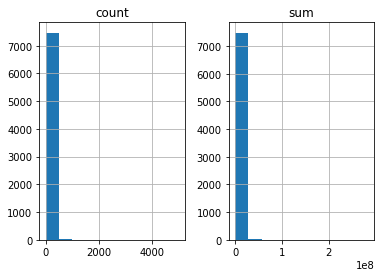

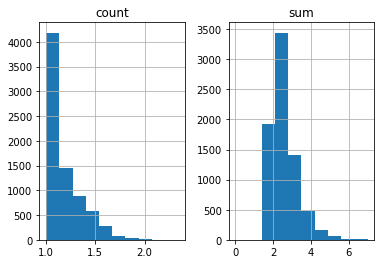

In [321]:
# Transformando as entradas pra uma forma mais gaussiana
grupo_credores.hist()

gp_cred_gaus = grupo_credores.transform(lambda x: x ** (1/10))
gp_cred_gaus.hist()

In [322]:
# Detectando outliers

#LocalOutlierFactor
lof = LocalOutlierFactor()
# lof.fit_predict(gp_cred_gaus)
gp_cred_gaus['outlier_lof'] = (lof.fit_predict(gp_cred_gaus) < 0)
grupo_credores['outlier_lof'] = (lof.fit_predict(grupo_credores) < 0)

# EllipticEnvelope (gaussian)
# TODO: verificar threshold
cov = EllipticEnvelope(random_state=0).fit(gp_cred_gaus)
gp_cred_gaus['outlier_gaus'] = (cov.predict(gp_cred_gaus) < 0)

cov = EllipticEnvelope(random_state=0).fit(grupo_credores)
grupo_credores['outlier_gaus'] = (cov.predict(grupo_credores) < 0)

gp_cred_gaus['outlier_or'] = np.logical_or(gp_cred_gaus['outlier_lof'], gp_cred_gaus['outlier_gaus'])
gp_cred_gaus['outlier_xor'] = np.logical_xor(gp_cred_gaus['outlier_lof'], gp_cred_gaus['outlier_gaus'])

grupo_credores['outlier_or'] = np.logical_or(grupo_credores['outlier_lof'], grupo_credores['outlier_gaus'])
grupo_credores['outlier_xor'] = np.logical_xor(grupo_credores['outlier_lof'], grupo_credores['outlier_gaus'])

gp_cred_gaus.head(10)

,count,sum,outlier_lof,outlier_gaus,outlier_or,outlier_xor
credor,,,,,,
COELBA,2.344048,5.875116,False,True,True,True
I.N.S.S. - FOLHA,2.332907,5.380835,True,True,True,False
COOPERSADE COOP.S.P.ESP.SAUDE,2.294123,6.476367,False,True,True,True
I.N.S.S. S/ PROCESSOS,2.221176,5.146414,True,True,True,False
TELEMAR,2.164670,4.894855,True,True,True,False
SIND EMP T.COL.FEIRA DE SANTAN,2.148621,5.337389,True,True,True,False
AUTO POSTO GASAUTO LTDA,2.138897,5.200114,False,True,True,True
EMBASA EMP BAIANA DE A E SANEA,2.117930,5.588210,False,True,True,True
EMBASA-EMP BAIANA AGUA E SANE,2.071649,4.188577,True,True,True,False


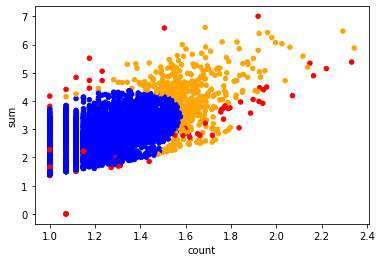

In [323]:
gp_cred_gaus['color'] = np.where(gp_cred_gaus['outlier_or'] == True, 'red', 'blue')
gp_cred_gaus['color'] = np.where(gp_cred_gaus['outlier_xor'] == True, 'orange', gp_cred_gaus['color'])

scatter_plt = gp_cred_gaus.plot.scatter(x='count', y='sum', c=gp_cred_gaus['color'])

# for i, cred in enumerate(gp_cred_gaus.index):
#     if i > 10:
#         break
#     scatter_plt.annotate(cred,
#                          (gp_cred_gaus['count'].iat[i], gp_cred_gaus['sum'].iat[i]),
#                          color=an_color(gp_cred_gaus.iloc[i])
#                           )
plt.show()

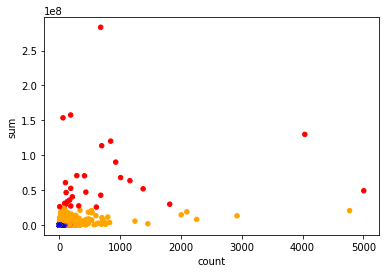

In [324]:
grupo_credores['color'] = np.where(grupo_credores['outlier_or'] == True, 'red', 'blue')
grupo_credores['color'] = np.where(grupo_credores['outlier_xor'] == True, 'orange', grupo_credores['color'])

scatter_plt = grupo_credores.plot.scatter(x='count', y='sum', c=grupo_credores['color'])

# for i, cred in enumerate(grupo_credores.index):
#     if i > 10:
#         break
#     scatter_plt.annotate(cred, (grupo_credores['count'].iat[i], grupo_credores['sum'].iat[i]))
plt.show()

# Prevendo os preços dos pagamentos

In [325]:
pagamentos.head()
# pagamentos.nunique()



,credor,valor,bem_ou_servico_prestado,natureza,acao,funcao,subfuncao,processo_licitatorio,fonte_recurso
13,AURIMAR GOMES MACHADO,30.00,DIARIA PARA IPECAETA,339014000000 - Diarias,2018 - Manutencao do IPFS,09 - PREVIDENCIA SOCIAL,122 - ADMINISTRACAO GERAL,isento,0003 - CONT.REGIME PRPPRIO PREV.SOCIA
14,EDINEY CARDOSO GOMES,30.00,DIARIA PARA IPECAETA,339014000000 - Diarias,2018 - Manutencao do IPFS,09 - PREVIDENCIA SOCIAL,122 - ADMINISTRACAO GERAL,isento,0003 - CONT.REGIME PRPPRIO PREV.SOCIA
15,CRISTIANE SILVA VILLA FLOR,30.00,DIARIA PARA IPECAETA,339014000000 - Diarias,2018 - Manutencao do IPFS,09 - PREVIDENCIA SOCIAL,122 - ADMINISTRACAO GERAL,isento,0003 - CONT.REGIME PRPPRIO PREV.SOCIA
18,TELEMAR-TELECOMUN.DA BAHIA SA,1213.20,despesa com telefone fixo da smt,339039430000 - Servicos de Telecomunicacoes,2142 - Manutencao da SMT,04 - ADMINISTRACAO,122 - ADMINISTRACAO GERAL,isento,0050 - REC.PROPRIAS ENT.ADM.
190,H.T.O HOSP.DE T.E ORTOPEDIA LT,101664.16,REF SERVICOS MEDICO PRESTADOS A PACIENTES DO SUS,339039360000 - Serv Medico Hospitalar Odont e ...,2056 - Atencao de Media e Alta Complexibilidad...,10 - SAUDE,302 - ASSISTENCIA HOSPITALAR E AMBUL,convite,0014 - TRANSF.REC. SUS
